(10, 10, 10000)
(10000, 101)
(10000, 1)
(10, 10, 10000)
(10, 10, 10000)
(10, 10, 10000, 2)
1


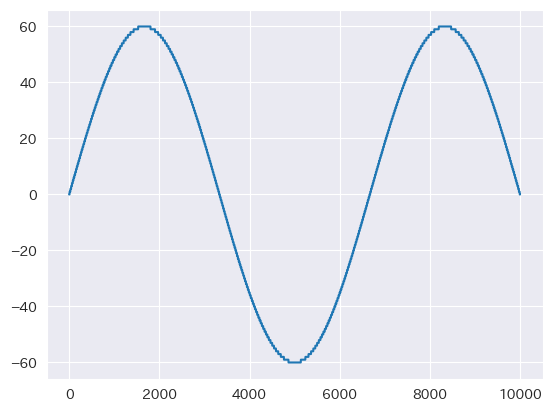

(10, 10, 10000, 2)
(10000, 10, 10, 2)
[0. 0. 0. ... 0. 0. 0.]
(8000, 10, 10, 2)
(1000, 10, 10, 2)
(1000, 10, 10, 2)
(8000, 181)
(1000, 181)
(1000, 181)


In [8]:
#GPUを用いて、tensorflowを使ったseq2seq回帰LSTMモデルを作成する
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import scipy.io

#データの読み込み
mat_file = 'mat/test_gen_bpsk_long.mat'
data = scipy.io.loadmat(mat_file)

#matファイルの中身の変数名を確認する

data.keys()
a = data['R_xx']
# a = data['R_xx_exist_Noise']
b = data['inputVec']
c = data['label']

# d=data['sigmaX2']
# e=data['t']
#matに保存した変数の呼び出し
#a,b,cの次元数を確認する
print(a.shape)
print(b.shape)
print(c.shape)

#共分散行列
R = a


# #入力信号の電力
# sigmax2=d
# #スナップショット数
# t=e

#実数部と虚数部(虚数単位jは外す)に分ける関数
def split_complex(x):
    real = np.real(x)
    imag = np.imag(x)
    return real, imag


#実数部と虚数部に分ける
real, imag = split_complex(R)

#実数部と虚数部の次元数を確認する
print(real.shape)
print(imag.shape)

#実数部と虚数部を結合し、四次元配列に変換する
R = np.stack([real, imag], axis=3)

#Rの次元数を確認する
print(R.shape)

#Rはx(t)=As(t)+n(t)という信号モデルの共分散行列(Rはx(t)の複素共役転置の期待値)である（Aは方向行列、s(t)は入力信号、n(t)はガウス雑音）
#Rには、本来Aとs(t)とn(t)の情報が含まれているが、今回はn(t)を含まない
#Rにn(t)を乗せる処理を書く
#SNRを定義する
SNR = np.empty((1, 1))
np.append(SNR, 30)

#送信電力とSNRから雑音電力を求める
#送信電力は、sigmaX2である
#雑音電力は、sigmaN2である
# def calculate_noise_covariance(sigmaX2, SNR, t, R):
#     # 送信電力から雑音電力を計算する
#     # sigman2 = np.divide(sigmaX2, (10**(SNR/10)))
#     #
#     # # sigmaN2を表示する
#     # print(sigman2)
#     #
#     # # ガウス分布に従う雑音n(t)を生成する
#     # noise = np.sqrt(sigman2/2) * (np.random.randn(len(t),len(R[:,0,0,0])) + 1j*np.random.randn(len(t),len(R[:,0,0,0])))
#     #
#     # # n(t)の次元数を確認する
#     # print(noise.shape)
#
#     # # n(t)の共分散行列を求める
#     # N = np.dot(np.conj(noise).T, noise)
#     # N = N / len(t)
#     #
#     # # Nの次元数を確認する
#     # print("R_n", N.shape)
#
#     # Nの実部と虚部を分割する
#     real, imag = np.real(N), np.imag(N)
#
#     # Nを結合して次元数を確認する
#     N = np.stack([real, imag], axis=2)
#     print("R_n", N.shape)
#
#     return N


from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

#tensorflowを使ったseq2seq回帰LSTMモデルを作成する

#分解能
min_angle = -90
max_angle = 90
resolution = 1

print(resolution)
#matファイルで読み込んだinputVecとlabelからデータセットを作成する
#データセットは、inputVecとlabelの組み合わせで、入力と出力を作成する
X = R
Y = (np.round(c / resolution)) * resolution

#Yをプロットする
plt.plot(Y)
plt.show()

#データセットを標準化する

#時系列画像データの標準化をする
#標準化すると、平均が0、標準偏差が1になる

from sklearn.preprocessing import StandardScaler

for j in range(X.shape[2]):
    for i in range(X.shape[3]):
        # シートごとのデータを抽出
        sheet_data = X[:, :, j, i]

        # 標準化器を作成し、データを標準化
        scaler = StandardScaler()
        sheet_data_standardized = scaler.fit_transform(sheet_data)

        # 標準化されたデータを元の配列に戻す
        X[:, :, j, i] = sheet_data_standardized

#データセットの特徴量の値の大部分が同じデータのみの場合にその行（もしくは列）を削除する

from sklearn.feature_selection import VarianceThreshold

for j in range(X.shape[2]):
    for i in range(X.shape[3]):
        sheet_data = X[:, :, j, i]  # シートごとのデータを抽出

        # VarianceThresholdを適用して行（もしくは列）を削除
        selector = VarianceThreshold()
        sheet_data_selected = selector.fit_transform(sheet_data)

        # 削除後のデータを元の配列に戻す
        if sheet_data_selected.ndim == 1:
            sheet_data_selected = sheet_data_selected.reshape(-1, 1)
        X[:, :, j, i] = sheet_data_selected

print(X.shape)
#Xを3次元配列に変換する
X = np.reshape(X, (X.shape[2], X.shape[0], X.shape[1], X.shape[3]))

print(X.shape)

from sklearn.model_selection import train_test_split
# from keras.utils import np_utils
import numpy as np
from sklearn.preprocessing import LabelBinarizer

#学習データセットと検証データセットとテストデータセットの分割割合を変数で指定する
train_size = 0.8
val_size = 0.1
test_size = 0.1

#Yを平坦化する
Y = Y.flatten()

#Yを表示する
print(Y)

from sklearn.preprocessing import LabelEncoder

#Yのユニークな値を表示する
u = np.arange(min_angle, max_angle + 1.0, resolution)

# import numpy as np
from sklearn.preprocessing import LabelBinarizer

transformer = LabelBinarizer().fit(u)

# ラベル → one-hot 表現
Y = transformer.transform(Y)
# print(Y)
# [[1 0 0]
#  [0 1 0]]

# # one-hot 表現 → ラベル
# src = transformer.inverse_transform(np.array([[1, 0, 0], [0, 1, 0]]))
# print(src)
# # ['A' 'B']

#Yを表示する
# print(target_one_hot)

#学習データセットと検証データセットとテストデータセットを分割する(シャッフルはしない)
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=1 - train_size, shuffle=False)
XVal, XTest, YVal, YTest = train_test_split(XTest, YTest, test_size=test_size / (test_size + val_size), shuffle=False)

#学習データセットと検証データセットとテストデータセットの次元数を確認する
print(XTrain.shape)
print(XVal.shape)
print(XTest.shape)
print(YTrain.shape)
print(YVal.shape)
print(YTest.shape)

#入力の次元はそれぞれ(サンプル数、タイムステップ数、特徴量)である
#Xの2番目の次元と3番目の次元を入れ替える
XTrain = np.swapaxes(XTrain, 1, 2)
XVal = np.swapaxes(XVal, 1, 2)
XTest = np.swapaxes(XTest, 1, 2)


In [9]:
import tensorflow as tf
from tensorflow.keras import layers

tf.config.list_physical_devices('GPU')

output_units=len(u)

# モデルの構築
model = tf.keras.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(10, 10, 2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(output_units, activation='sigmoid')
])

# モデルのコンパイル
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [10]:
# モデルのサマリを表示
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          304       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 32)          4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [11]:

history = model.fit(XTrain, YTrain, epochs=10, validation_data=(XVal, YVal))
# モデルのサマリを表示
model.summary()


Epoch 1/10
250/250 [==============================] - 1s 2ms/step - loss: 0.1016 - accuracy: 0.0270 - val_loss: 0.0268 - val_accuracy: 0.2470
Epoch 2/10
250/250 [==============================] - 0s 2ms/step - loss: 0.0325 - accuracy: 0.0339 - val_loss: 0.0267 - val_accuracy: 0.1410
Epoch 3/10
250/250 [==============================] - 1s 2ms/step - loss: 0.0318 - accuracy: 0.0408 - val_loss: 0.0260 - val_accuracy: 0.2460
Epoch 4/10
250/250 [==============================] - 1s 2ms/step - loss: 0.0314 - accuracy: 0.0384 - val_loss: 0.0266 - val_accuracy: 0.0450
Epoch 5/10
250/250 [==============================] - 1s 2ms/step - loss: 0.0311 - accuracy: 0.0406 - val_loss: 0.0259 - val_accuracy: 0.1530
Epoch 6/10
250/250 [==============================] - 1s 2ms/step - loss: 0.0309 - accuracy: 0.0432 - val_loss: 0.0264 - val_accuracy: 0.1990
Epoch 7/10
250/250 [==============================] - 1s 2ms/step - loss: 0.0307 - accuracy: 0.0441 - val_loss: 0.0271 - val_accuracy: 0.0580
Epoch 

In [12]:
# モデルの評価
test_loss, test_acc = model.evaluate(XTest, YTest, verbose=2)
print(test_acc)


32/32 - 0s - loss: 0.0320 - accuracy: 0.0030 - 43ms/epoch - 1ms/step
0.003000000026077032


In [13]:
# モデルの保存
model.save('my_model.h5')


In [14]:
#